In [160]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import sympy as sp

In [161]:
os.getcwd()

'/mnt/c/Users/admin/Documents/workspace/fyp'

The general matrix method will be solved for an open-open duct with no mean flow, assuming harmoic vibrations

$$ \mathbf{M} \begin{bmatrix} A_0 \\ B_0 \end{bmatrix} = \mathbf{0} $$

where 

$$ \mathbf{M} = \begin{bmatrix} 1 & -R_{u} \\ R_{d}exp\left(-\frac{i\omega L}{\bar{c}} \right) & -exp\left(\frac{i\omega L}{\bar{c}} \right) \end{bmatrix} $$


The aim is to solve for $\omega$ such that $det(\mathbf{M}) = 0$

In [162]:
# Defining variables
c = 345 # m/s, speed of sound
L = 0.75 # m, length of tube
Ru = -1 # upstream reflection coefficient
Rd = -1 # downstream refection coefficient
j = complex(0, 1)
e = np.e

# Function which returns the determinent of the matrix M
def matrix_det(w, Ru, Rd):
    det = -sp.exp(j*w*L/c) + Rd*Ru*sp.exp(-j*w*L/c)
    return det

In [198]:
# using solver to solve for w which gives det(M) = 0
w = sp.Symbol('w')
wl = sp.solveset(matrix_det(w, Ru, Rd), w, domain=S.Complexes)

In [264]:
wl

ImageSet(Lambda(_n, 460.0*_n*pi), Integers)

In [263]:
# Converting infinite set into generator object, taking first 20 elements and adding to a list
wl_iterable = iter(wl)
wl_list = [float(next(wl_iterable)) for i in range(20)]
wl_arr = np.asarray(wl_list)

In [269]:
# Function for calculating pressure fluctuations, saying A0 = 1
x = np.linspace(0, L, 100)
x = x[..., np.newaxis]

def p_fluc(wl):
    return np.exp((j*wl*(-x/c))) + 1/Ru*e**(j*wl*x/c)
    # return np.exp((j*wl*(-x/c))) + Rd*e**(2*j*wl*L/c)*e**(j*wl*x/c)

In [270]:
p_fluc(wl_arr[1:10]).shape

(100, 9)

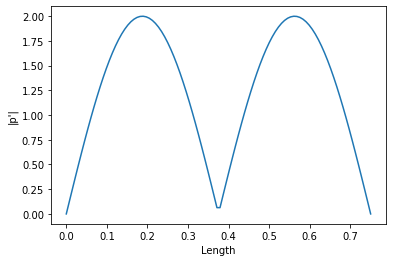

In [277]:
n = 10
p = p_fluc(wl_list[n])
plt.plot(x, np.abs(p_fluc(wl_arr[3])))
plt.ylabel('|p\'|')
plt.xlabel('Length')
plt.show()